In [13]:
from functions import *

In [14]:
# Initialization
fs = 250 #Hz
lf = 1 #Hz
hf = 30 #Hz
# chan_name = ['POz', 'PO3', 'PO4', 'PO7', 'O2', 'O1', 'Oz', 'PO8']
# from now using these channels

chan_name = ['POz', 'PO3', 'PO8', 'PO7', 'PO4', 'O1', 'Oz', 'O2']
n_chan = len(chan_name)
chan_list = ['ch' + str(i) for i in range(1, n_chan + 1)]

In [15]:
# Import data
eeg_data = []
eeg_data.append(EEG_Data(pd.read_csv('data/BinocularVR-22March/experiment1_ExG.csv'), title='experiment1_ExG'))
eeg_data.append(EEG_Data(pd.read_csv('data/BinocularVR-22March/experiment2_ExG.csv'), title='experiment2_ExG'))

In [16]:
# Add the signal data
for eeg in eeg_data:
    eeg.raw_signal = eeg.data[chan_list].to_numpy().T

# Filter the signal
for eeg in eeg_data:
    eeg.filtered_signal = filt(eeg.raw_signal, fs, lf, hf)

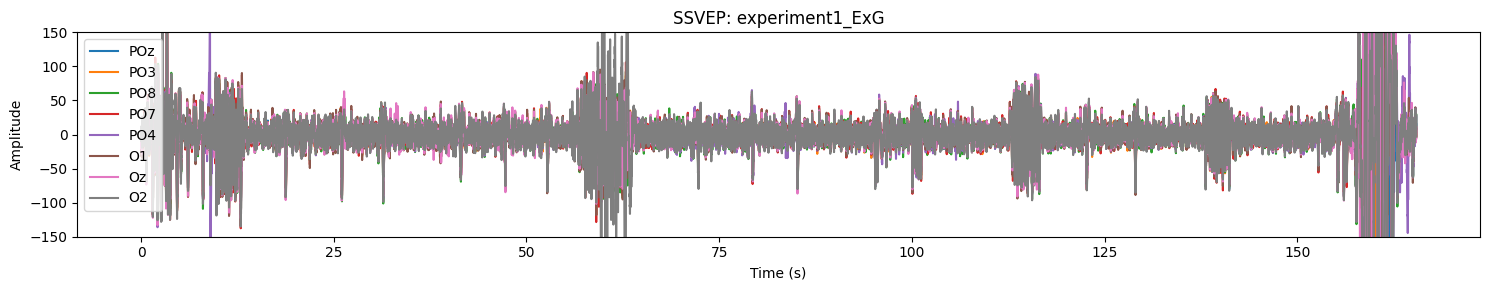

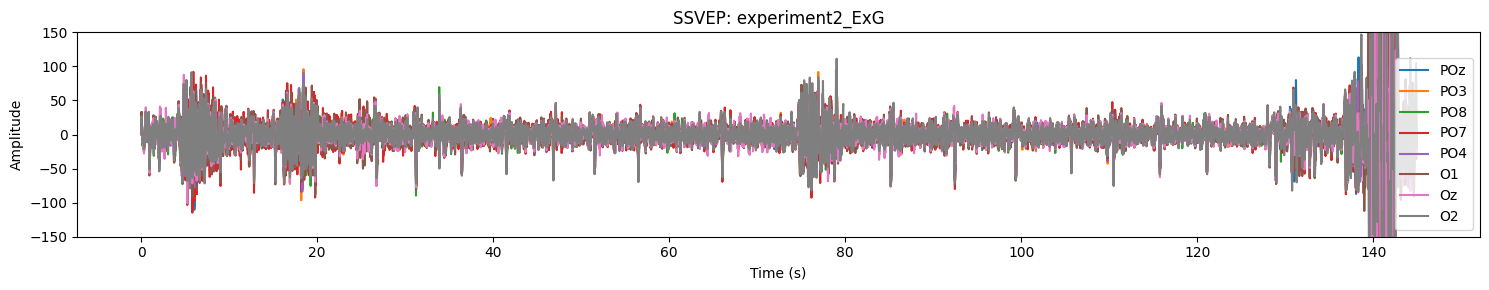

In [17]:
# Plot the signal amplitude VS time
for eeg in eeg_data:
    amplitude_plot(eeg.filtered_signal, chan_name, title=("SSVEP: "+eeg.title))

In [18]:
# TODO: automate this
# add cut start and cut end
eeg_data[0].cut_start = 20
eeg_data[0].cut_end = 10

eeg_data[1].cut_start = 30
eeg_data[1].cut_end = 20

eeg_data[2].cut_start = 5
eeg_data[2].cut_end = 3

IndexError: list index out of range

In [ ]:
# Cut the signal so that the first 20 seconds and the last 10 seconds are removed
for eeg in eeg_data:
    if eeg.cut_start:
        eeg.filtered_signal = cut_signal(eeg.filtered_signal,eeg.cut_start,eeg.cut_end)
    else:
        eeg.filtered_signal = cut_signal(eeg.filtered_signal,20,20)    

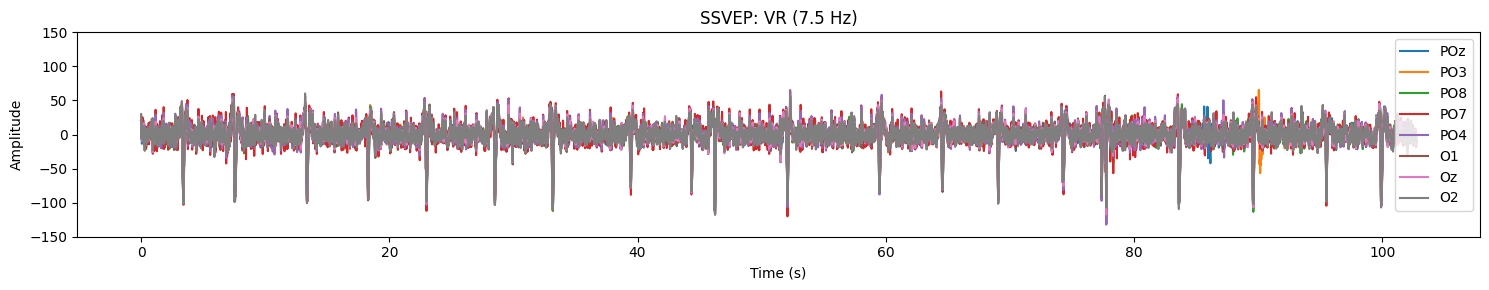

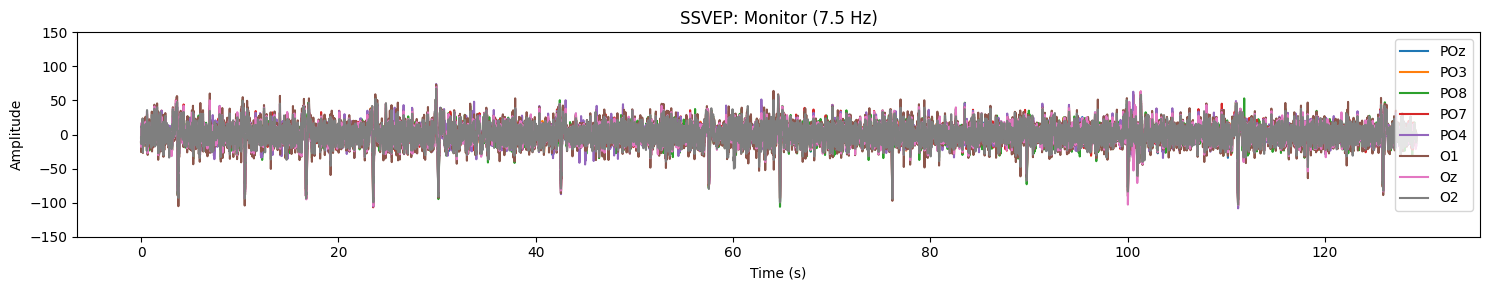

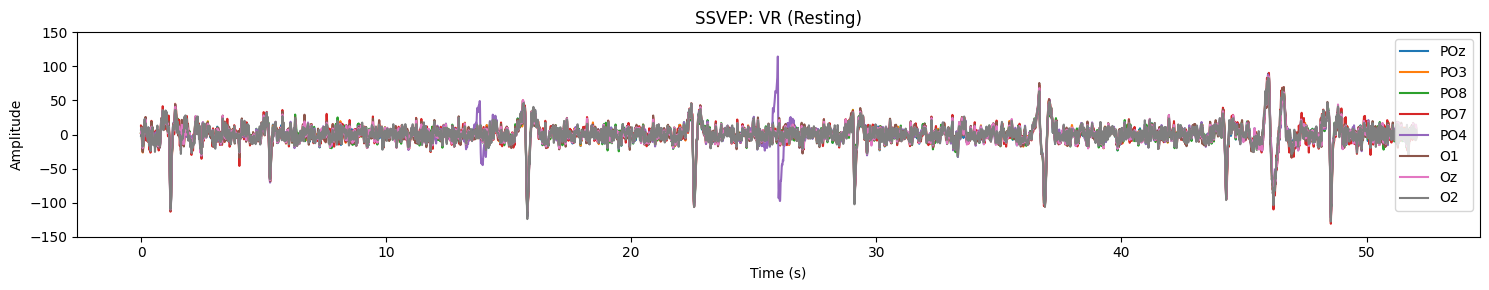

In [ ]:
# Plot the signal amplitude VS time
for eeg in eeg_data:
    amplitude_plot(eeg.filtered_signal, chan_name, title=("SSVEP: "+eeg.title))

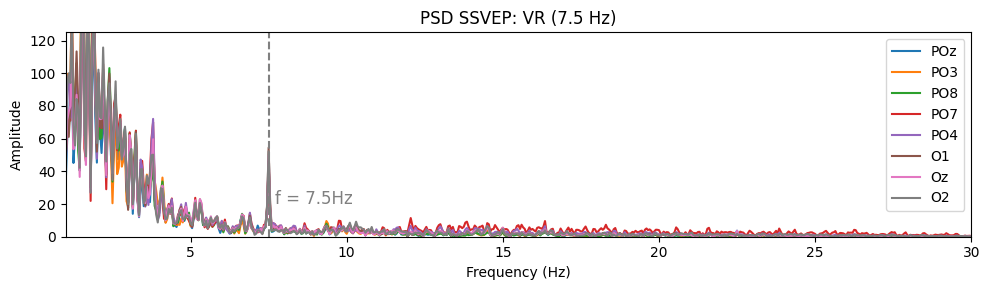

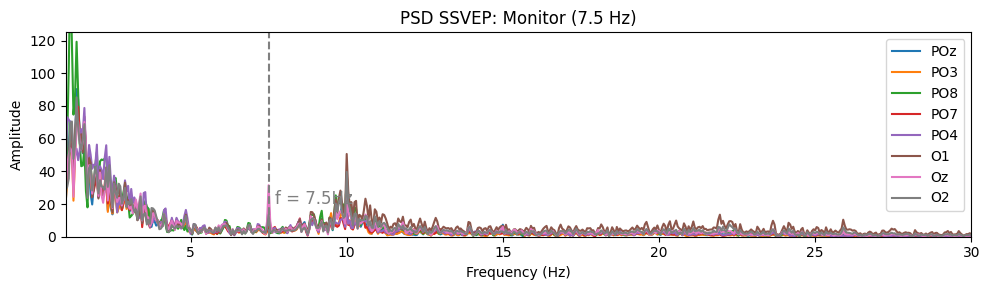

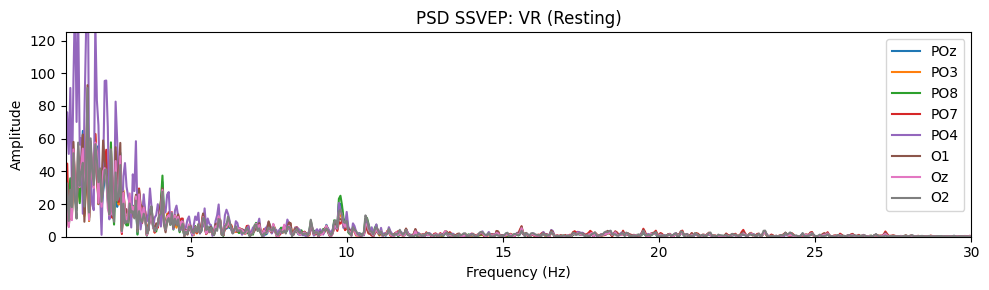

In [ ]:
# Plot the signal PSD
for eeg in eeg_data:
    psd_plot(eeg.filtered_signal, chan_name, title=("SSVEP: "+eeg.title), line=eeg.stimulus_frequency)

In [ ]:
%%capture 
# get the min stimulus frequency from the eeg data
min_freq = 5
for eeg in eeg_data:
    if eeg.stimulus_frequency:
        if eeg.stimulus_frequency <= min_freq:
            min_freq = eeg.stimulus_frequency - 2

# get the max stimulus frequency from the eeg data
max_freq = 15
for eeg in eeg_data:
    if eeg.stimulus_frequency:
        if eeg.stimulus_frequency >= max_freq:
            max_freq = eeg.stimulus_frequency+2

freqs = np.arange(min_freq, max_freq, .3)
n_cycles = freqs
t_min, t_max = 1, 6

# Reshape the signal to epochs
for eeg in eeg_data:
    eeg.epochs = reshape_to_epochs(eeg.filtered_signal, epoch_length=t_max)

# Get the class names
class_names = [eeg.title for eeg in eeg_data]

times = np.linspace(t_min, t_max, eeg_data[0].epochs.shape[2])

# compute power for each epoch
power = []
for eeg in eeg_data:
    power.append(mne.time_frequency.tfr_array_morlet(eeg.epochs, sfreq=fs, freqs=freqs, n_cycles=n_cycles, output='avg_power'))

power_stack = np.stack(power)

for pow in power:
    mne.baseline.rescale(pow, times, (None, times[0]), mode='mean', copy=False)
    
power = power_stack

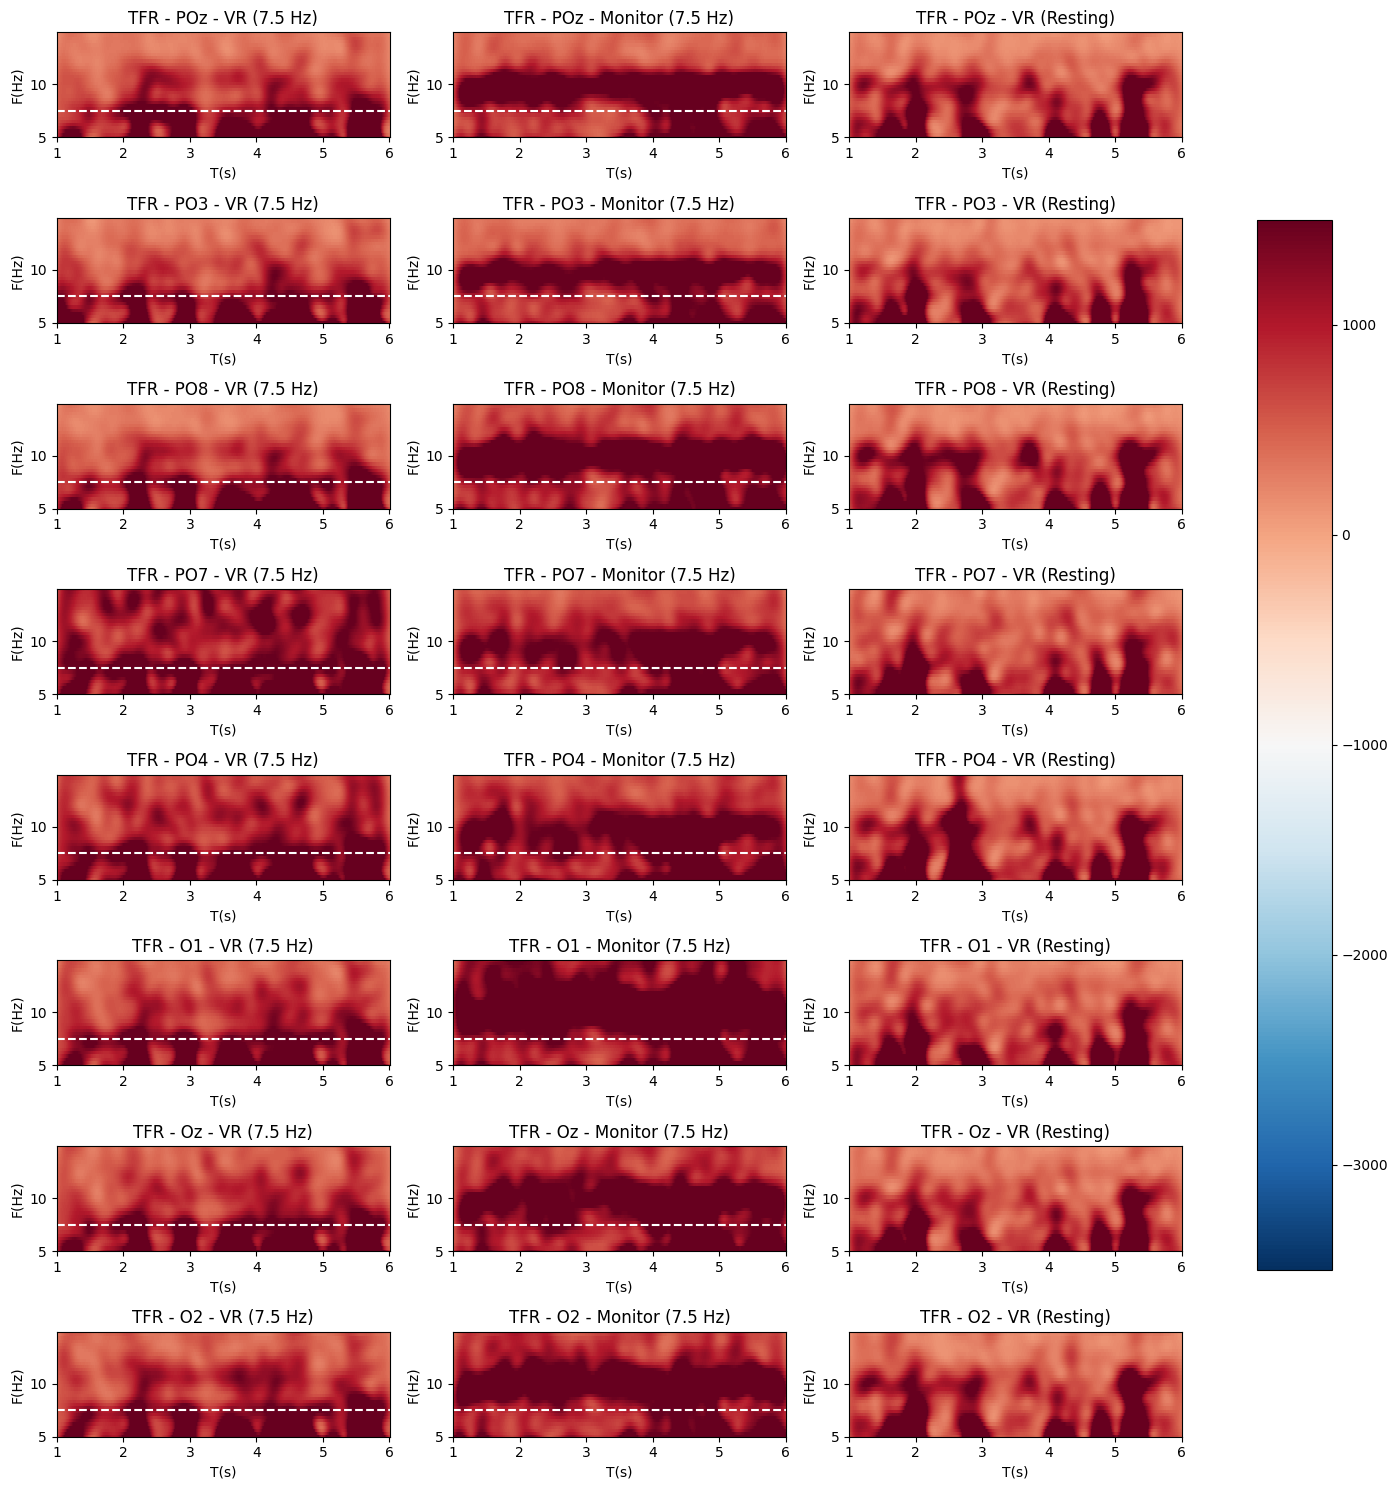

In [ ]:
x, y = mne.viz.centers_to_edges(times, freqs)

fig, ax = plt.subplots(n_chan, len(class_names), figsize=(15, 15))
for j in range(len(class_names)):
    for i in range(n_chan):
        mesh = ax[i, j].pcolormesh(x, y, power[j, i], cmap='RdBu_r', vmin=-3500, vmax=1500)
        ax[i, j].set_title('TFR - ' + chan_name[i] + ' - ' + class_names[j])
        ax[i, j].set(ylim=freqs[[0, -1]], xlabel='T(s)', ylabel='F(Hz)')
        if eeg_data[j].stimulus_frequency:
            ax[i, j].axhline(y=eeg_data[j].stimulus_frequency, linestyle='--', color='white')
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(mesh, cax=cbar_ax)
plt.show()